In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score, confusion_matrix
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma
from scipy.optimize import linear_sum_assignment

### Function for data extraction

In [4]:
def data_and_param_extract(N_runs):
    
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_5/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)
        
    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)    

    ## tau
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    ## group changes
    group_changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_changes/group_changes_list_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_changes_list.append(data)
    
    ## group memberships
    group_memberships_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_memberships/group_memberships_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_memberships_list.append(data)

    ## true memberships
    true_groups_list = []
    for j in range(N_runs):
        file_path = base_path + f"true_groups/true_groups_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        true_groups_list.append(data)


    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['tau'] = tau_list
    output_dict['group_changes'] = group_changes_list
    output_dict['group_memberships'] = group_memberships_list
    output_dict['true_groups'] = true_groups_list

    return output_dict

In [5]:
num_nodes = int(500)
num_groups = int(3)
n_cavi = int(3)
num_fp_its = int(3)
int_length = float(0.1)
T_max = float(5)

group_sizes = np.array([200, 200, 100])
group_sizes_prime = np.array([num_nodes])
rho_matrix = np.array([[1]]) # Fully-connected

rate_matrices = []
Delta = 0.1
for n in range(50):
    matrix = np.zeros((3, 3))
    matrix[0, 0] = 2 * np.sin(2 * np.pi / 5 * n * Delta) + 5
    matrix[0, 1] = 0.1 * np.sin(2 * np.pi / 5 * n * Delta) + 0.2
    matrix[0, 2] = 0.05 * np.sin(2 * np.pi / 5 * n * Delta) + 0.1
    matrix[1, 0] = 0.2 * np.cos(2 * np.pi / 5 * n * Delta) + 1
    matrix[1, 1] = np.cos(2 * np.pi / 5 * n * Delta) + 2
    matrix[1, 2] = 0.01 * np.sin(2 * np.pi / 5 * n * Delta) + 0.8
    matrix[2, 0] = 0.1 * np.cos(2 * np.pi / 5 * n * Delta) + 0.9
    matrix[2, 1] = 0.1 * np.sin(2 * np.pi / 5 * n * Delta) + 0.5
    matrix[2, 2] = 0.01 * np.cos(2 * np.pi / 5 * n * Delta) + 0.03
    rate_matrices.append(matrix)

### Define macros

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [
    (208/255, 28/255, 139/255),  
    (241/255, 182/255, 218/255),  
    (184/255, 225/255, 134/255),  
    (77/255, 172/255, 38/255),    
    (136/255, 86/255, 167/255),   
    (230/255, 97/255, 1/255),     
    (253/255, 184/255, 99/255),   
    (127/255, 191/255, 123/255),  
    (37/255, 104/255, 178/255)    
]

### Compute adjusted rand index


In [28]:
data_dict = data_and_param_extract(50)  
true_groups = data_dict['true_groups']
tau_store = data_dict['tau']

_ARI_list_time = []
for run in range(50):
    _ARI_list_run = []
    true_groups_curr = true_groups[run]

    # Up to group membership change
    for time_step in range(31):
        _pred_groups = tau_store[run][time_step,:,:].argmax(axis=1)
        _ARI = adjusted_rand_score(_pred_groups, true_groups_curr[0])
        _ARI_list_run.append(_ARI)
    
    # After group membership change
    for time_step in range(31, 51):
        _pred_groups = tau_store[run][time_step,:,:].argmax(axis=1)
        _ARI = adjusted_rand_score(_pred_groups, true_groups_curr[1])
        _ARI_list_run.append(_ARI)

    _ARI_list_time.append([l for l in _ARI_list_run])
    

### Compute posterior means and simulation envelopes

In [20]:
alpha_list = data_dict['alpha']; beta_list = data_dict['beta']
mean_sim = []; upper_sim = []; lower_sim = []
for run in range(50):
    tau_store = data_dict['tau'][run]
    group_memberships = tau_store.argmax(axis=2)
    true_groups = data_dict['true_groups'][run]

    alpha_run = alpha_list[run]; beta_run = beta_list[run]
    gamma_rv = gamma(a = alpha_run, scale = 1 / beta_run)

    mean_sim.append(gamma_rv.mean())
    upper_sim.append(gamma_rv.ppf(0.975))
    lower_sim.append(gamma_rv.ppf(0.025))
    
    # Adjust for labelling differences
    conf_mat = confusion_matrix(group_memberships[5],
                                true_groups[0])
    row_indices, col_indices = linear_sum_assignment(-conf_mat)
    optimal_mapping = dict(zip(row_indices, col_indices))
    aligned_memberships = np.array([
        [optimal_mapping[label] for label in row]  # Align each row
        for row in group_memberships
    ])

mean_sim = np.stack(mean_sim).mean(axis=0)
lower_sim = np.stack(lower_sim).mean(axis=0)
upper_sim = np.stack(upper_sim).mean(axis=0)

### Plot the posterior means and ARI

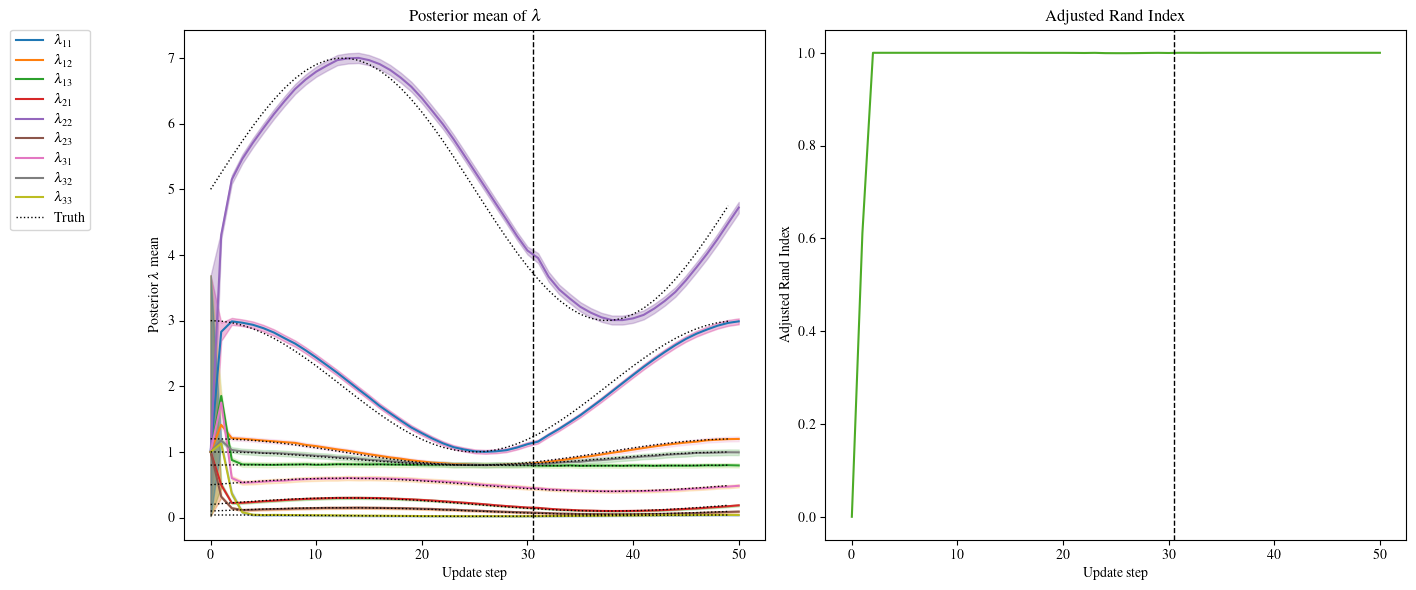

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

### POSTERIOR MEAN RATE
colour_idx = -1
for k in range(num_groups):
    for m in range(num_groups):
        colour_idx += 1
        label = r'$\lambda_{%d%d}$' % (k+1, m+1)
        axs[0].plot(np.arange(51), 
                    mean_sim[:,k,m],
                    label=label)
        axs[0].fill_between(np.arange(51), lower_sim[:,k,m], upper_sim[:,k,m],
                                      alpha=0.3, color = colours[colour_idx])

axs[0].plot(np.stack(rate_matrices)[:, 0, 0], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 0, 1], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 0, 2], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 1, 0], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 1, 1], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 1, 2], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 2, 0], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 2, 1], linewidth=1, linestyle='dotted', color='black')
axs[0].plot(np.stack(rate_matrices)[:, 2, 2], linewidth=1, linestyle='dotted', color='black',
            label='Truth')
axs[0].axvline(30.5, linewidth=1, linestyle='--', color='black')

axs[0].set_xlabel('Update step')
axs[0].set_ylabel(r'Posterior $\lambda$ mean')
axs[0].legend(loc='upper left', bbox_to_anchor=(-0.3, 1.0), borderaxespad=0.0)
axs[0].set_title('Posterior mean of $\lambda$')

### ARI
ARI = _ARI_list_time
temp_array = np.array([np.array(entry) for entry in ARI])
mean_ARI = temp_array.mean(axis=0)

axs[1].plot(np.arange(51), mean_ARI, color=colours[3])
axs[1].axvline(30.5, linewidth=1, linestyle='--', color='black')
axs[1].set_ylabel('Adjusted Rand Index')
axs[1].set_xlabel('Update step')
axs[1].set_title('Adjusted Rand Index')

plt.tight_layout()
# plt.show()
base_path = "analyses/simulation_studies/simulation_output/simulation_study_5/"
plt.savefig(f"{base_path}plots/posterior_means_ARI.pdf", bbox_inches='tight');